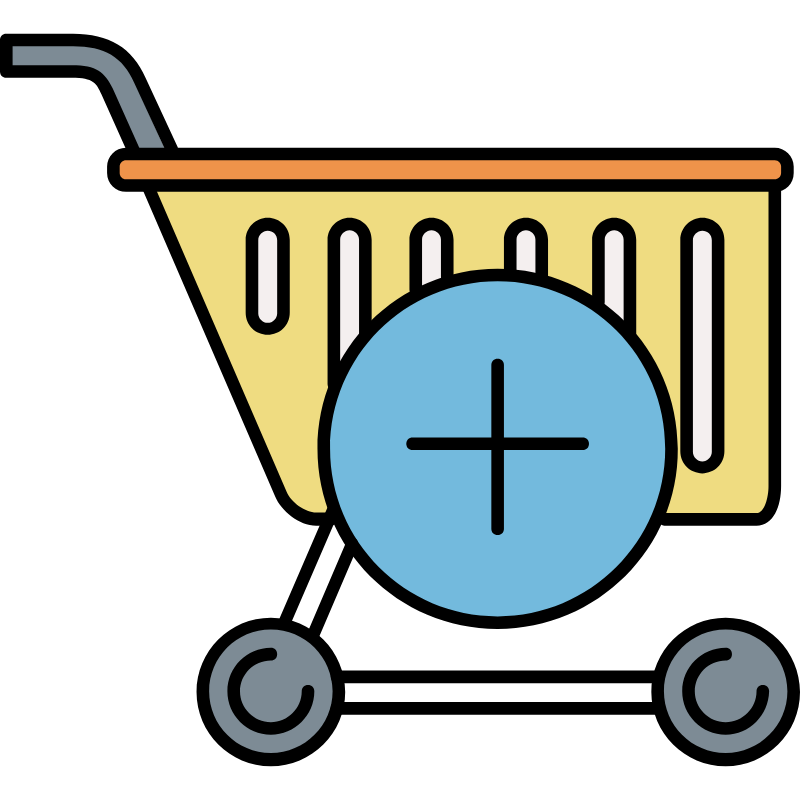
## **Online Retail Store Data Analysis**

### 1.1 Introduction

This notebook demonstrates data cleaning and exploratory analysis on an online retail store data using python language. The approach is typical of tasks one can execute on real business data using Data Science skills. The original dataset for this analysis is from [Kraggle](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce). Specific tasks to be performed are:

- data cleaning,
- examining and analyzing the data to see what insights I can extract from it.

Individual datasheets gathered from the retail store are as follows:

- Customer Information
- Order Item Information
- Payment Information
- Reviews Data
- Products
- Seller information
- Translations for category names
- Order Information, including shipping
- geographical location


### 1.2 Business Questions
To help identify opportunities for growth and understand the platform even better, I will provide answers to the business questions below;

- What is the total revenue generated by the online retailer, and how has it changed over time?
- How many orders were placed, and how does this vary by month or season?
- What are the most popular product categories, and how do their sales volumes compare to each other?
- What is the average order value (AOV), and how does this vary by product category or payment method?
- How many sellers are active, and how does this number change over time?
- What is the distribution of seller ratings, and how does this impact sales performance?
- How many customers have made repeat purchases, and what percentage of total sales do they account for?
- What is the average customer rating for products sold, and how does this impact sales performance?
- What is the average order cancellation rate, and how does this impact seller performance?
- What are the top-selling products, and how have their sales trends changed over time?
- Which payment methods are most commonly used by the retailer's customers, and how does this vary by product category or geographic region?
- How do customer reviews and ratings affect sales and product performance?
- Which product categories have the highest profit margins, and how can the company increase profitability across different categories?
- How does the retailer’s marketing spend and channel mix impact sales and customer acquisition costs, and how can the company optimize its marketing strategy to increase ROI?
- Geolocation having high customer density. Calculate customer retention rate according to geolocations.

### 1.3 Install Required Libraries

In [ ]:
!pip install geopandas matplotlib
!pip install basemap

### 1.4 Importing Libraries

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#Import the Basemap toolkit
from mpl_toolkits.basemap import Basemap

from datetime import datetime

import plotly.express as px

%matplotlib inline

### **2. Geo Exploratory**

In [4]:
# Load dataset
geo_df = pd.read_csv('geo_loc.csv')

In [ ]:
geo_df.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [5]:
# Check dataset info

print(geo_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB
None


In [6]:
# Create a GeoDataFrame:

gdf = gpd.GeoDataFrame(
    geo_df, geometry=gpd.points_from_xy(geo_df.geolocation_lng, geo_df.geolocation_lat))

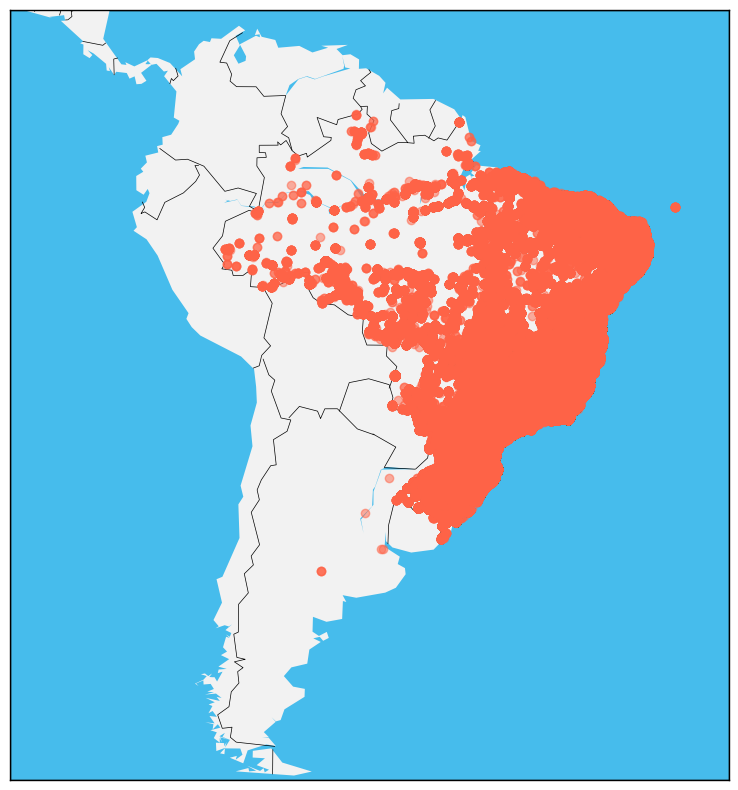

In [7]:
# Plot population density map

lat = gdf['geolocation_lat']
lon = gdf['geolocation_lng']

plt.figure(figsize=(10,10))

m = Basemap(llcrnrlat=-55.401805,llcrnrlon=-92.269176,urcrnrlat=13.884615,urcrnrlon=-27.581676)
m.bluemarble()
m.drawmapboundary(fill_color='#46bcec') # Make your map into any style you like
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec') # Make your map into any style you like
#m.drawcoastlines()
m.drawcountries()
m.scatter(lon, lat,zorder=10,alpha=0.5,color='tomato')

Most of Brazil population lived on the east coast and a much smaller proportion lived on the west side.

More product orders, therefore come from the east coast due to its highest shopping rate based on the population density.

<ipython-input-8-b0d9e88f36f3>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x ='geolocation_state', data=geo_df,


<Axes: xlabel='geolocation_state', ylabel='count'>

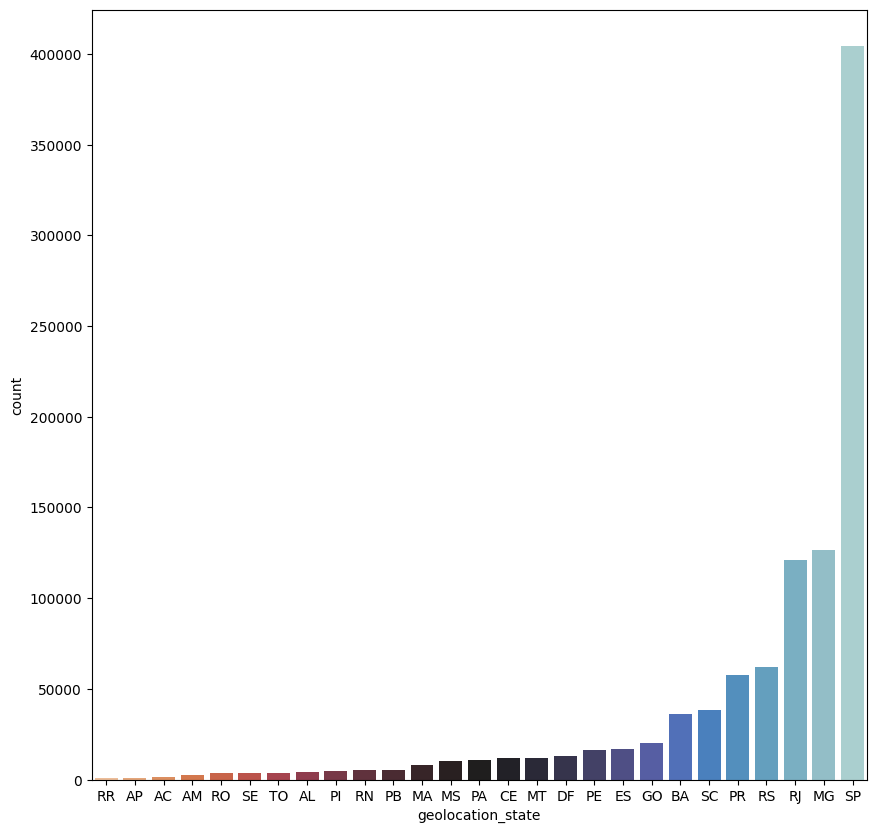

In [8]:
# Plot of orders by state

plt.figure(figsize=(10,10))
sns.countplot(x ='geolocation_state', data=geo_df,
              order=geo_df['geolocation_state'].value_counts().sort_values().index,
              palette='icefire_r')

The graph shows that São Paulo has the highest rate of product orders whilst there is a huge gap between the rest of the states.

### **3. Data Exploratory**

### 3.1 Loading Data

**Note:** The individual data sheets are shown as .csv files in the current repository.

In [9]:
#Customers
cust = pd.read_csv('customers.csv')

#Order Items
odr_item = pd.read_csv('order_items.csv')

#Payment Information
pay = pd.read_csv('payment_info.csv')

#Reviews
review = pd.read_csv('reviews.csv')

#Products
prod = pd.read_csv('products.csv')

#Seller information
seller = pd.read_csv('seller_info.csv')

#Translations
trans = pd.read_csv('translations.csv')

#Orders Information, including shipping
orders = pd.read_csv('orders.csv')

In [10]:
# Function to print dataset shape for each dataset in the format - File Name with no extension: Shape

def print_shape(data_list):
  for df in data_list:
    print(df.name + ": " + str(df.shape))

data_list = [cust, odr_item, pay, review, prod, seller, trans, orders]
# Set the name attribute for each DataFrame
cust.name = 'customers'
odr_item.name = 'order_items'
pay.name = 'payment_info'
review.name = 'reviews'
prod.name = 'products'
seller.name = 'seller_info'
trans.name = 'translations'
orders.name = 'orders'
print_shape(data_list)


customers: (99441, 5)
order_items: (112650, 7)
payment_info: (103886, 5)
reviews: (99224, 7)
products: (32951, 9)
seller_info: (3095, 4)
translations: (71, 2)
orders: (99441, 8)


In [11]:
# Function to print information for each dataset. Separate each dataset information with ==== line covering the page width

def print_info(data_list):
  for df in data_list:
    print(df.name)
    print(df.info())
    print("="*80)

print_info(data_list)


customers
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None
order_items
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_d

### 3.2 Feature Engineering

Some features need to be modified for purposes of proper analysis.

In [12]:
# Calculate the percentage of null values in 'order_delivered_customer_date'
null_percentage = (orders['order_delivered_customer_date'].isnull().sum() / len(orders)) * 100

# Display the percentage
print("Percentage of null 'order_delivered_customer_date': {:.2f}%".format(null_percentage))


Percentage of null 'order_delivered_customer_date': 2.98%


Since the percentage is small, we can fill in the null values

In [13]:
# Fill in the null order_delivered_customer_date values in orders using forward-fill method

orders['order_delivered_customer_date'].fillna(method='ffill', inplace=True)


<ipython-input-13-ed54ccc9fc28>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  orders['order_delivered_customer_date'].fillna(method='ffill', inplace=True)


In [14]:
# check sum of null order_delivered_customer_date values in orders

orders['order_delivered_customer_date'].isnull().sum()


0

Check distribution of transactions by year and month

In [15]:
# Making all of the date datetime format
orders[['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date',
        'order_estimated_delivery_date']] = orders[['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
                                                    'order_delivered_customer_date', 'order_estimated_delivery_date']].apply(pd.to_datetime)

In [16]:
# percentage of total transactions by month and year in orders

# Extract year and month from 'order_purchase_timestamp'
orders['order_purchase_year'] = orders['order_purchase_timestamp'].dt.year
orders['order_purchase_month'] = orders['order_purchase_timestamp'].dt.month

# Calculate the count of transactions for each year and month combination
transaction_counts = orders.groupby(['order_purchase_year', 'order_purchase_month'])['order_id'].count().reset_index(name='count')

# Calculate the total number of transactions
total_transactions = transaction_counts['count'].sum()

# Calculate the percentage of total transactions for each year and month combination
transaction_counts['percentage'] = (transaction_counts['count'] / total_transactions) * 100

# Display the percentage of total transactions by month and year
print(transaction_counts[['order_purchase_year', 'order_purchase_month', 'percentage']])


    order_purchase_year  order_purchase_month  percentage
0                  2016                     9    0.004022
1                  2016                    10    0.325821
2                  2016                    12    0.001006
3                  2017                     1    0.804497
4                  2017                     2    1.790006
5                  2017                     3    2.697077
6                  2017                     4    2.417514
7                  2017                     5    3.720799
8                  2017                     6    3.263242
9                  2017                     7    4.048632
10                 2017                     8    4.355346
11                 2017                     9    4.309088
12                 2017                    10    4.657033
13                 2017                    11    7.586408
14                 2017                    12    5.704890
15                 2018                     1    7.309862
16            

In [17]:
# check redefined orders info
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  99441 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
 8   order_purchase_year            99441 non-null  int32         
 9   order_purchase_month           99441 non-null  int32         
dtypes: datetime64[ns](5), int32(2), object(3)
memory usage: 6.8+ MB


### 3.3 Time-based delivery features

Delivered time and Estimate time features:

In [18]:
orders['delivered_time']=pd.to_datetime(orders['order_delivered_customer_date'],
                                            format='%Y-%m-%d').dt.date
orders['estimate_time']=pd.to_datetime(orders['order_estimated_delivery_date'],
                                           format='%Y-%m-%d').dt.date

Weekly feature:

In [19]:
orders['weekly'] = pd.to_datetime(orders['order_delivered_customer_date'],
                                  format='%Y-%m-%d').dt.isocalendar().week

Yearly feature:

In [20]:
orders['yearly']=pd.to_datetime(orders['order_delivered_customer_date'])\
                    .dt.to_period('M')
orders['yearly']= orders['yearly'].astype(str)

Days of delivered and estimated times:

In [21]:
# Ensure both columns are in datetime format
orders['delivered_time'] = pd.to_datetime(orders['delivered_time'])
orders['estimate_time'] = pd.to_datetime(orders['estimate_time'])

# Calculate the difference and extract the number of days
orders['diff_days'] = (orders['delivered_time'] - orders['estimate_time']).dt.days

In [22]:
# check features for orders dataset

orders.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  99441 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
 8   order_purchase_year            99441 non-null  int32         
 9   order_purchase_month           99441 non-null  int32         
 10  delivered_time                 99441 non-null  datetime64[ns]
 11  estimate_time  

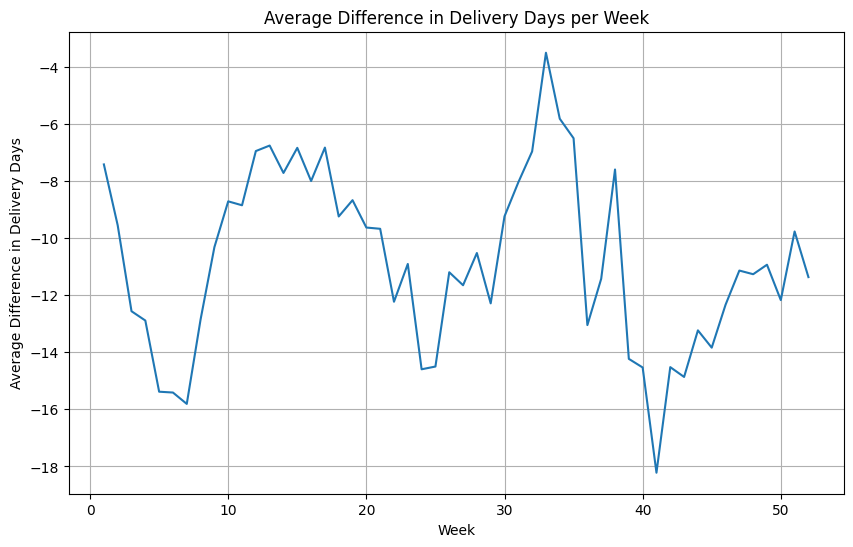

In [23]:
# check average diff_days for all deliveries per week for orders dataset and plot the data for easy visualization

# Calculate average diff_days per week
avg_diff_per_week = orders.groupby('weekly')['diff_days'].mean().reset_index()

# Plot the data
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(avg_diff_per_week['weekly'], avg_diff_per_week['diff_days'])
plt.xlabel('Week')
plt.ylabel('Average Difference in Delivery Days')
plt.title('Average Difference in Delivery Days per Week')
plt.grid(True)
plt.show()


From the graph above, all deliveries were made before their estimated date.

- The earliest deliveries were made in October. It means that this month is the least intensive period in those years.
- Latest deliveries have been made at the end of June and beginning of August. It means that this time is the most intensive period in those years.

### 3.4 Top products/categories/by week

Orders and order item data will be merged

In [24]:
#Merge data
ttl_orders=pd.merge(orders, odr_item)
prod_orders=pd.merge(ttl_orders,prod, on="product_id")
prod_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112650 non-null  object        
 1   customer_id                    112650 non-null  object        
 2   order_status                   112650 non-null  object        
 3   order_purchase_timestamp       112650 non-null  datetime64[ns]
 4   order_approved_at              112635 non-null  datetime64[ns]
 5   order_delivered_carrier_date   111456 non-null  datetime64[ns]
 6   order_delivered_customer_date  112650 non-null  datetime64[ns]
 7   order_estimated_delivery_date  112650 non-null  datetime64[ns]
 8   order_purchase_year            112650 non-null  int32         
 9   order_purchase_month           112650 non-null  int32         
 10  delivered_time                 112650 non-null  datetime64[ns]
 11  

Shortening product_id since its too long by taking the last eight characters, uniqueness preserved.

In [25]:
# check unique product_id

len(prod_orders['product_id'].unique())

32951

In [26]:
# check preservation of product_id uniqueness after shortening length

len(prod_orders['product_id'].str[-8:].unique())

32951

In [27]:
prod_orders['product_id_shorten']=prod_orders['product_id'].str[-8:]

Text(0.5, 1.0, 'Top 10 Products')

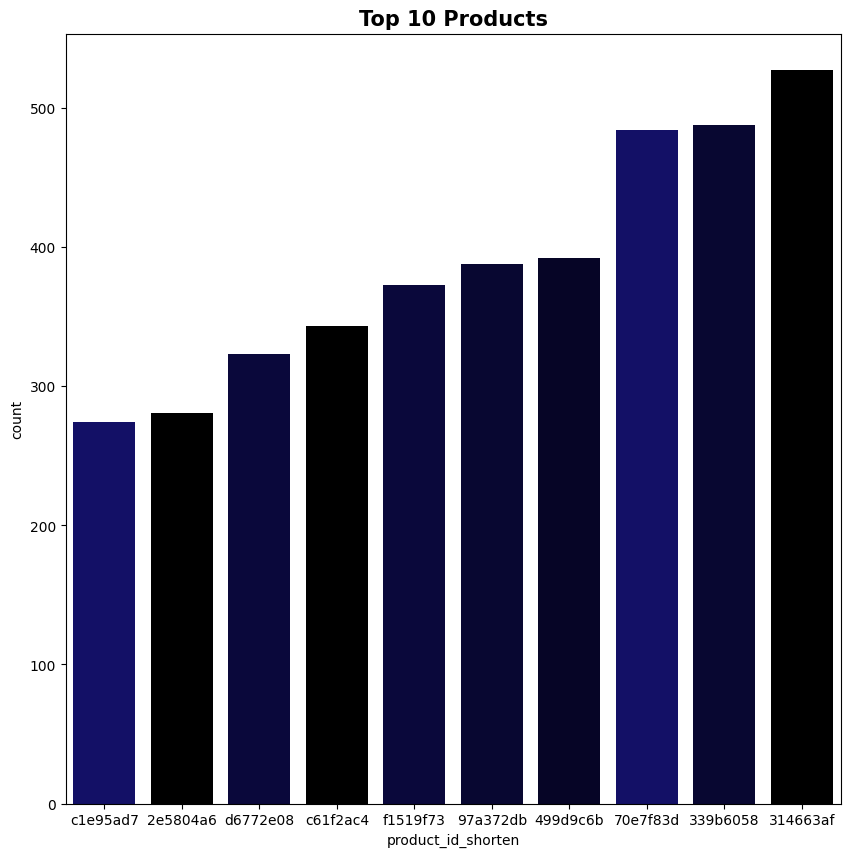

In [28]:
#Plotting Top 10 Products
plt.figure(figsize=(10,10))
sns.countplot(x='product_id_shorten', data=prod_orders,  hue = 'product_id_shorten', legend=False, palette='gist_earth',
             order=prod_orders['product_id_shorten'].value_counts()[:10]\
             .sort_values().index).set_title("Top 10 Products", fontsize=15,
                                             weight='bold')

In [29]:
# Tabular presentation of Top 10 products' category

prod_orders.groupby(["product_category_name"])["product_id_shorten"].count().sort_values(ascending=False).head(10)

,product_id_shorten
product_category_name,
cama_mesa_banho,11115
beleza_saude,9670
esporte_lazer,8641
moveis_decoracao,8334
informatica_acessorios,7827
utilidades_domesticas,6964
relogios_presentes,5991
telefonia,4545
ferramentas_jardim,4347


According to the table, cama_mesa_banho [bed_table_bath] orders have the highest one.

In [30]:
group_category= prod_orders.groupby(['product_id_shorten','product_category_name',])['product_id_shorten']\
                                        .count().sort_values(ascending=False).head(10)
group_category

,,product_id_shorten
product_id_shorten,product_category_name,
314663af,moveis_decoracao,527
339b6058,cama_mesa_banho,488
70e7f83d,ferramentas_jardim,484
499d9c6b,ferramentas_jardim,392
97a372db,ferramentas_jardim,388
f1519f73,ferramentas_jardim,373
c61f2ac4,informatica_acessorios,343
d6772e08,relogios_presentes,323
2e5804a6,beleza_saude,281


The top ordered product's category is a moveis_decoracao [home decoration].

### 3.5 Top sellers/categories/by week

Seller dataset will be merged with the product orders data.

In [31]:
seller_prod = pd.merge(prod_orders, seller, on="seller_id")
seller_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112650 non-null  object        
 1   customer_id                    112650 non-null  object        
 2   order_status                   112650 non-null  object        
 3   order_purchase_timestamp       112650 non-null  datetime64[ns]
 4   order_approved_at              112635 non-null  datetime64[ns]
 5   order_delivered_carrier_date   111456 non-null  datetime64[ns]
 6   order_delivered_customer_date  112650 non-null  datetime64[ns]
 7   order_estimated_delivery_date  112650 non-null  datetime64[ns]
 8   order_purchase_year            112650 non-null  int32         
 9   order_purchase_month           112650 non-null  int32         
 10  delivered_time                 112650 non-null  datetime64[ns]
 11  

 The seller id name needed to be shortened.

In [32]:
# check size of unique seller id

len(seller_prod['seller_id'].unique())

3095

In [33]:
# check presevation uniqueness after shortening

len(seller_prod['seller_id'].str[-6:].unique())

3095

In [34]:
seller_prod['seller_id_shorten']=seller_prod['seller_id'].str[-6:]

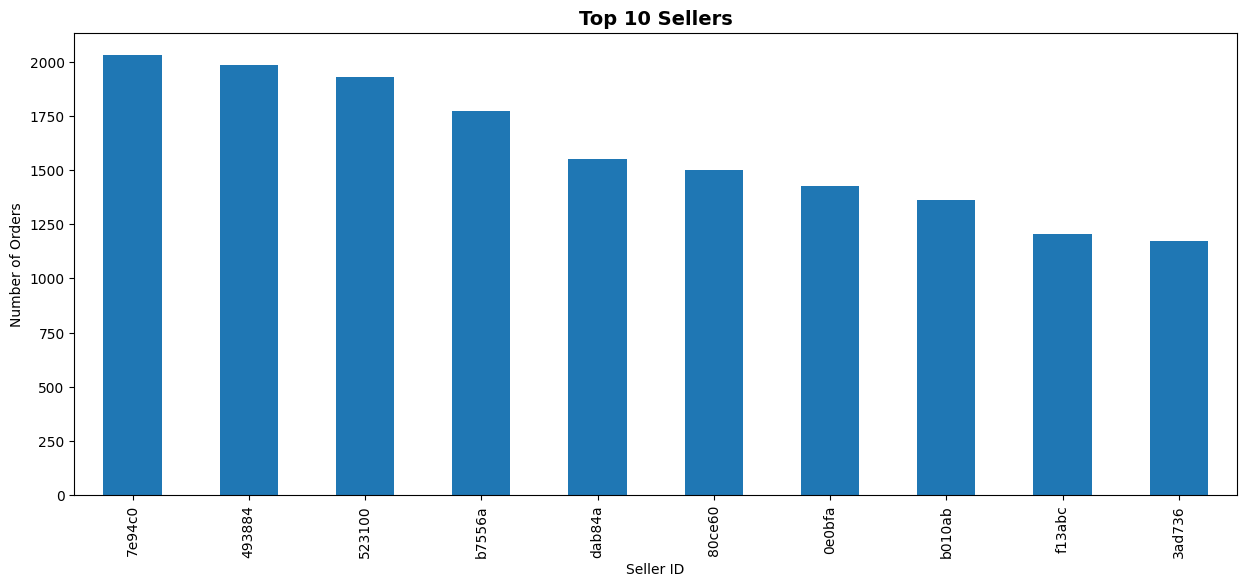

In [35]:
# Plot bar chart of Top 10 Sellers

plt.figure(figsize=(15, 6))
seller_prod['seller_id_shorten'].value_counts()[:10].plot(kind='bar')
plt.title("Top 10 Sellers", size=14, weight='bold')
plt.xlabel("Seller ID")
plt.ylabel("Number of Orders")
plt.show()


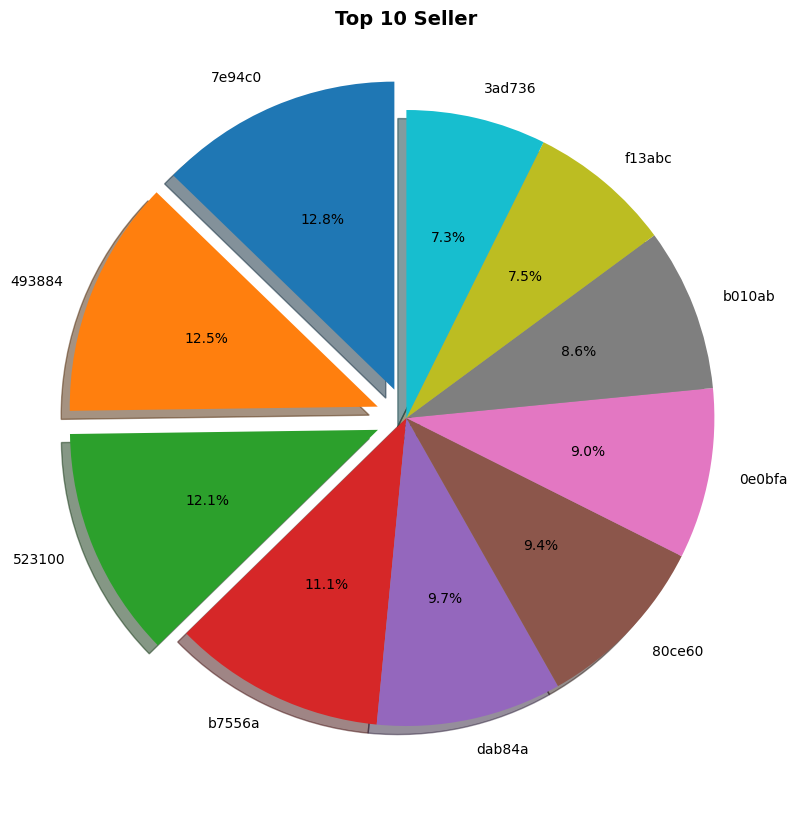

In [36]:
# Plot pie chart of Top 10 Sellers. The top 3 are slightly separated from the main chart

plt.figure(figsize=(20,10))
seller_counts = seller_prod['seller_id_shorten'].value_counts()[:10]
explode = [0.1 if i < 3 else 0 for i in range(10)]  # Explode the top 3 slices
plt.pie(seller_counts, labels=seller_counts.index, autopct='%1.1f%%',
        shadow=True, startangle=90, explode=explode)
plt.title("Top 10 Seller",size=14, weight='bold')
plt.show()

In [37]:
seller_category= seller_prod.groupby(['seller_id_shorten', 'product_category_name'])\
                        ['seller_id_shorten'].count().sort_values(ascending=False).head(10)
seller_category

,,seller_id_shorten
seller_id_shorten,product_category_name,
523100,ferramentas_jardim,1882
7e94c0,relogios_presentes,1628
493884,cama_mesa_banho,1572
0e0bfa,moveis_decoracao,1292
dab84a,cama_mesa_banho,1277
b010ab,moveis_escritorio,1233
f13abc,telefonia,1178
b7556a,beleza_saude,1091
3ad736,cool_stuff,1069


Top 10 sellers category, and since they can sell multiple product types, ferramentas_jardim [garden tools] are the most selling product of the best seller.

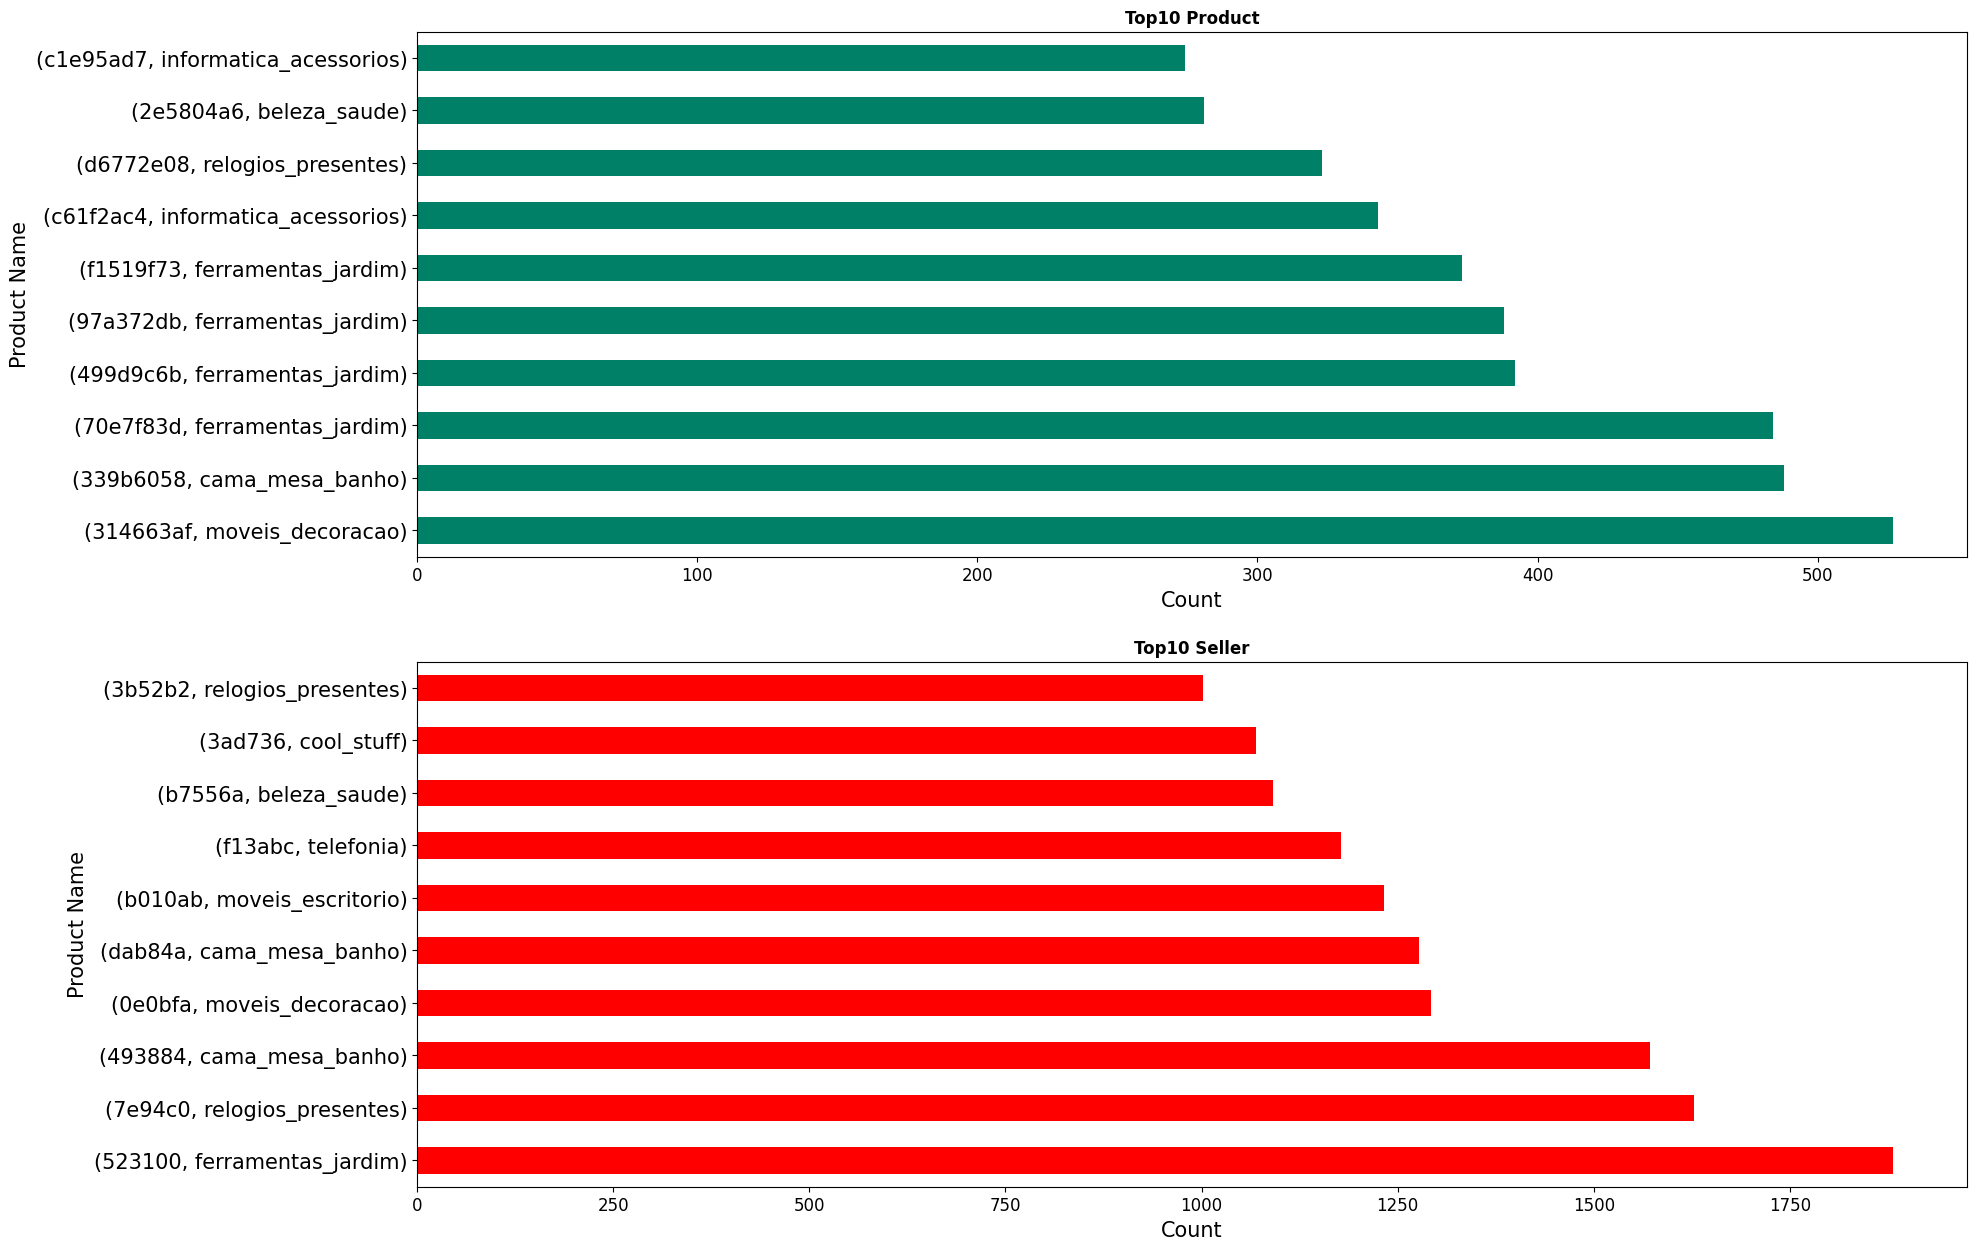

In [38]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,15))
group_category.plot.barh(ax=ax1, cmap='summer')
seller_category.plot.barh(ax=ax2, cmap='autumn')

ax1.set_title('Top10 Product', fontweight='bold')
ax2.set_title('Top10 Seller', fontweight='bold')

ax1.set_xlabel('Count', fontsize=15)
ax1.set_ylabel('Product Name', fontsize=15)
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=15)

ax2.set_xlabel('Count', fontsize=15)
ax2.set_ylabel('Product Name', fontsize=15)
ax2.xaxis.set_tick_params(labelsize=12)
ax2.yaxis.set_tick_params(labelsize=15)

The graphs show the top products and top sellers category. While most selling product item belongs to the moveis_decoracao [home decoration], most seller item belongs to ferramentas_jardim [garden tools].

We can then examine the most selling product's weekly purchased numbers, which is 314663af and belong to home decoration.

In [39]:
# First creating new feature of weeks
prod_orders['order_week']= pd.to_datetime(prod_orders['order_purchase_timestamp'],
                                            format='%Y-%m-%d').dt.isocalendar().week

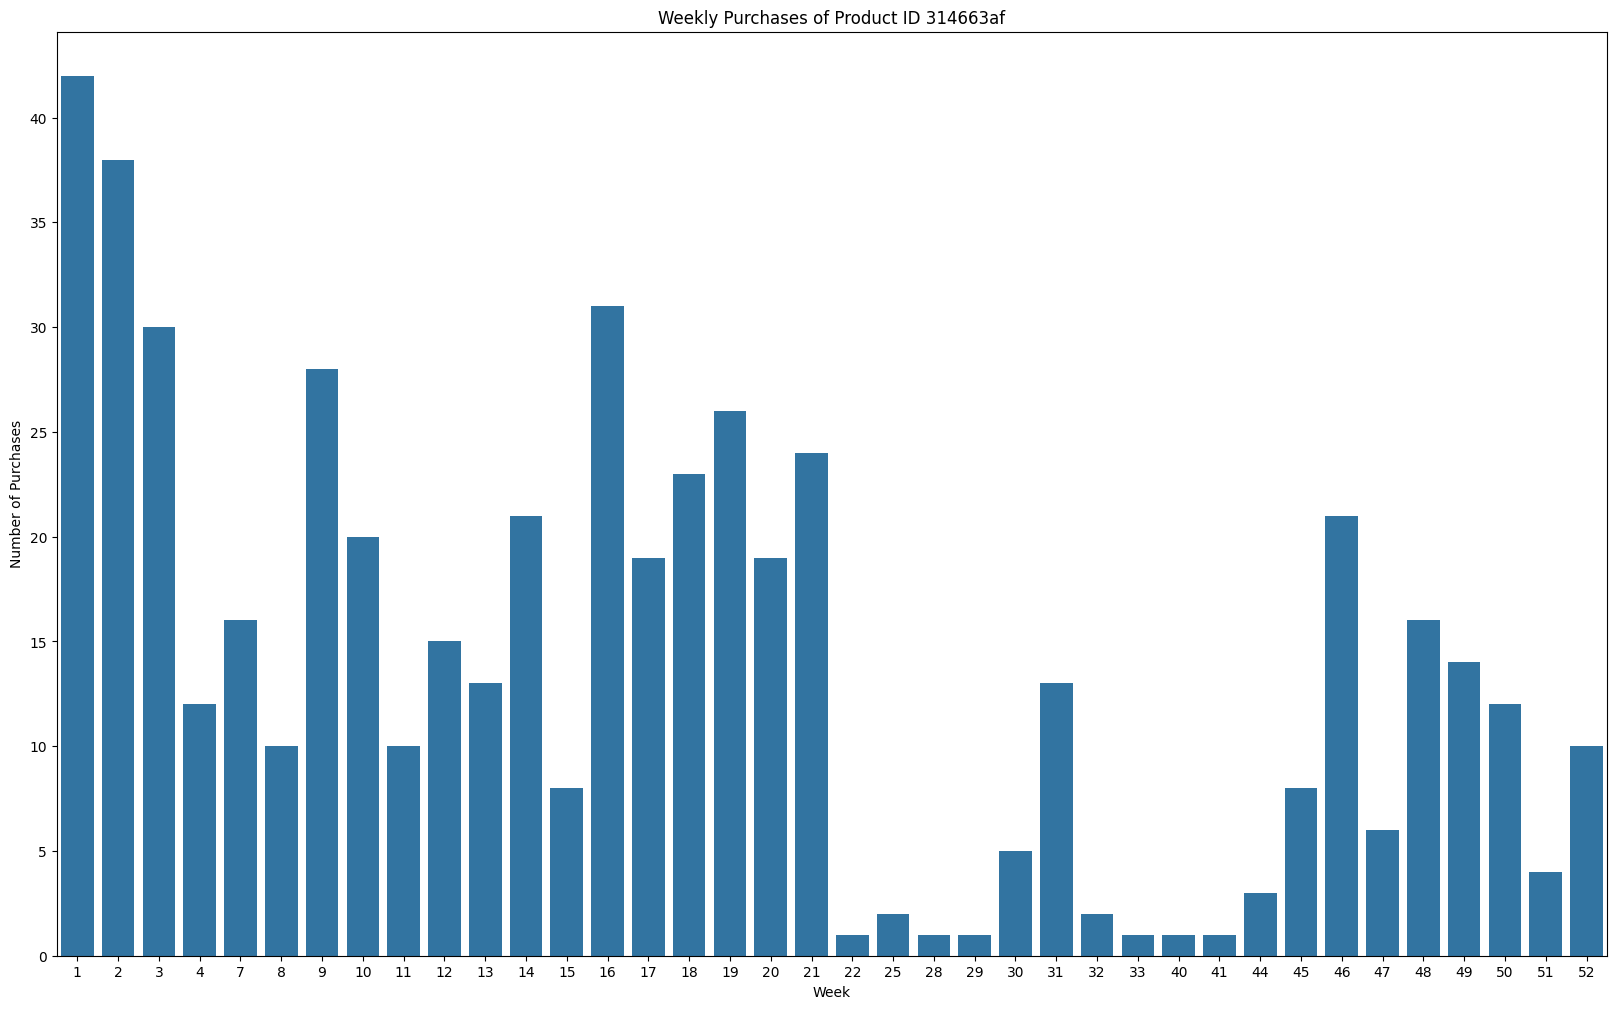

In [40]:
# plot showing the weekly purchased number of product_id_shorten = 314663af

# Filter the DataFrame for the specific product_id_shorten
product_df = prod_orders[prod_orders['product_id_shorten'] == '314663af']

# Group by order_week and count the occurrences
weekly_counts = product_df.groupby('order_week')['product_id_shorten'].count().reset_index(name='count')

# Create the countplot
plt.figure(figsize=(20, 12))
sns.countplot(x='order_week', data=product_df)
plt.xlabel('Week')
plt.ylabel('Number of Purchases')
plt.title('Weekly Purchases of Product ID 314663af')
plt.show()


 The graph above shows the weekly purchased number of 314663af. The months with the least purchases are June and August. In the rest of the months, at least one week is the highest purchase of those months.

We can also examine the most selling product category weekly.

In [41]:
#Weekly popular items
items_weekly =prod_orders.groupby(['order_week','product_category_name'])\
                        ['product_category_name'].count().sort_values(ascending=False)
#Change to data frame
most_products= items_weekly.reset_index(name='count')

In [42]:
#Find the max value of row
max_selling_products= most_products[most_products['count']
                            == most_products.groupby(['order_week'])\
                            ['count'].transform(max)]
max_selling_products.head(10)

<ipython-input-42-d8131e611b84>:4: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  ['count'].transform(max)]


,order_week,product_category_name,count
0,47,cama_mesa_banho,438
2,33,cama_mesa_banho,355
3,29,cama_mesa_banho,339
4,32,beleza_saude,330
5,8,informatica_acessorios,330
8,31,beleza_saude,320
9,9,informatica_acessorios,314
10,19,beleza_saude,310
11,18,beleza_saude,302
12,23,cama_mesa_banho,301


In [43]:
max_selling_products['product_category_name'].value_counts()

,count
product_category_name,
cama_mesa_banho,33
beleza_saude,10
informatica_acessorios,3
esporte_lazer,3
moveis_decoracao,2
brinquedos,1


The table above shows that 33 of 52 weeks the most selling's product is bed_table_bath. This category is in the top 3 either most selling product group or most sellers group.

### 3.6 Payment analysis

- payment methods
- gross profits / by product/ periodical

In [44]:
payments=pd.merge(seller_prod, pay, on="order_id")
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117601 entries, 0 to 117600
Data columns (total 38 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       117601 non-null  object        
 1   customer_id                    117601 non-null  object        
 2   order_status                   117601 non-null  object        
 3   order_purchase_timestamp       117601 non-null  datetime64[ns]
 4   order_approved_at              117586 non-null  datetime64[ns]
 5   order_delivered_carrier_date   116356 non-null  datetime64[ns]
 6   order_delivered_customer_date  117601 non-null  datetime64[ns]
 7   order_estimated_delivery_date  117601 non-null  datetime64[ns]
 8   order_purchase_year            117601 non-null  int32         
 9   order_purchase_month           117601 non-null  int32         
 10  delivered_time                 117601 non-null  datetime64[ns]
 11  

In [121]:
# distribution of payment_type

fig = px.histogram(payments, x="payment_type", color="payment_type", title="Distribution of Payment Types",
                   labels={"payment_type": "Payment Type"},
                   width=800, height=600)
fig.update_layout(bargap=0.1,
                  xaxis_title="Payment Type",
                  yaxis_title="Count",
                  font=dict(family="Arial", size=12, color="black"),
                  plot_bgcolor='white',
                  paper_bgcolor='lightgray')
fig.update_traces(marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.7)
fig.show()


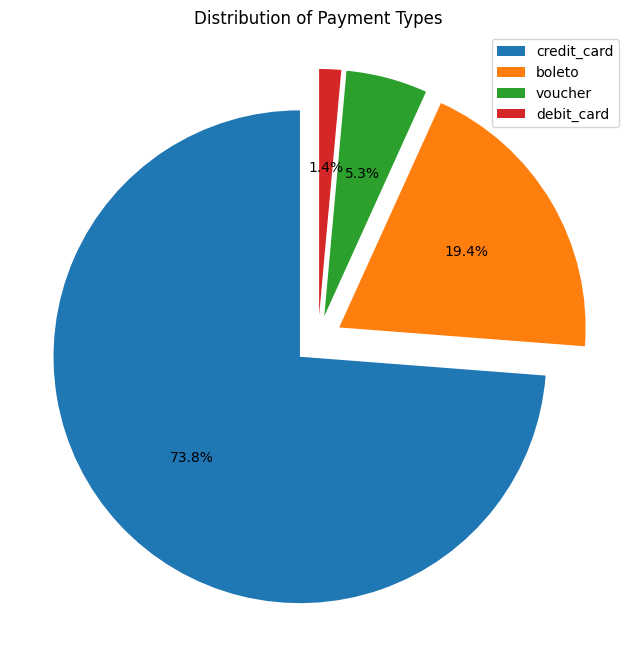

In [120]:
# Pie chart for distribution of payment_type

# Calculate the value counts for each payment type
payment_counts = payments['payment_type'].value_counts()

# Create the pie chart
plt.figure(figsize=(10, 8))
plt.pie(payment_counts, labels=None, autopct='%1.1f%%', startangle=90, explode=[0.1] * len(payment_counts))
plt.title("Distribution of Payment Types")
plt.legend(labels=payment_counts.index, loc="best")
plt.show()


- Only four (4) types of payments are used by the retail customers

- 73.8% of customers prefer paying with credit card, followed by 19.4% that use boleto.

In [45]:
# drop irrelevant columns to make data more handy
payments= payments.drop(columns=['product_name_lenght','product_description_lenght',
                                 'product_photos_qty','product_weight_g','product_length_cm',
                                 'product_height_cm','product_width_cm'])

In [46]:
price_details= payments.groupby(['order_id','price','product_category_name',
                                 'yearly','weekly'])[['freight_value','payment_value']].sum().reset_index()

Total order value can be calculated by sum of price and freight value.

In [47]:
price_details['total_order_value'] = price_details['price'] + price_details['freight_value']

Calculate Gross Profit and Profit Margin by payment value and total order value.

In [48]:
price_details['gross_profit'] = price_details['payment_value']- price_details['total_order_value']
price_details['profit_margin'] = price_details['gross_profit']/price_details['payment_value']
price_details['profit_margin'] = price_details['profit_margin'].astype('int64')

In [49]:
price_details.sort_values('gross_profit', ascending=False).head(10)

,order_id,price,product_category_name,yearly,weekly,freight_value,payment_value,total_order_value,gross_profit,profit_margin
1466,03caa2c082116e1d31e67e9ae3700499,1680.00,telefonia_fixa,2017-10,42,224.08,109312.64,1904.08,107408.56,0
66523,ab14fdcfbe524636d65ee38360e22ce8,98.70,automotivo,2017-09,35,288.80,45256.00,387.50,44868.50,0
10548,1b15974a0141d54e36626dca3fdc731a,100.00,informatica_acessorios,2018-03,10,202.40,44048.00,302.40,43745.60,0
17262,2cc9089445046817a7539d90805e6e5a,989.10,agro_industria_e_comercio,2017-12,50,146.94,36489.24,1136.04,35353.20,0
90941,e8fa22c3673b1dd17ea315021b1f0f61,284.99,bebidas,2018-05,18,168.70,30186.00,453.69,29732.31,0
44991,736e1922ae60d0d6a89247b851902527,1790.00,telefonia_fixa,2018-07,30,114.88,29099.52,1904.88,27194.64,0
25844,428a2f660dc84138d969ccd69a0ab6d5,65.49,moveis_decoracao,2017-12,50,243.30,18384.75,308.79,18075.96,0
22593,3a213fcdfe7d98be74ea0dc05a8b31ae,108.00,relogios_presentes,2018-01,4,186.24,17786.88,294.24,17492.64,0
96747,f80549a97eb203e1566e026ab66f045b,137.90,informatica_acessorios,2017-09,39,388.10,17671.00,526.00,17145.00,0
26447,4412d97cb2093633afa85f11db46316c,120.00,informatica_acessorios,2018-06,23,83.99,15978.65,203.99,15774.66,0


Text(0.5, 1.0, 'Gross Profit of Top 5 Products (2016-2018)')

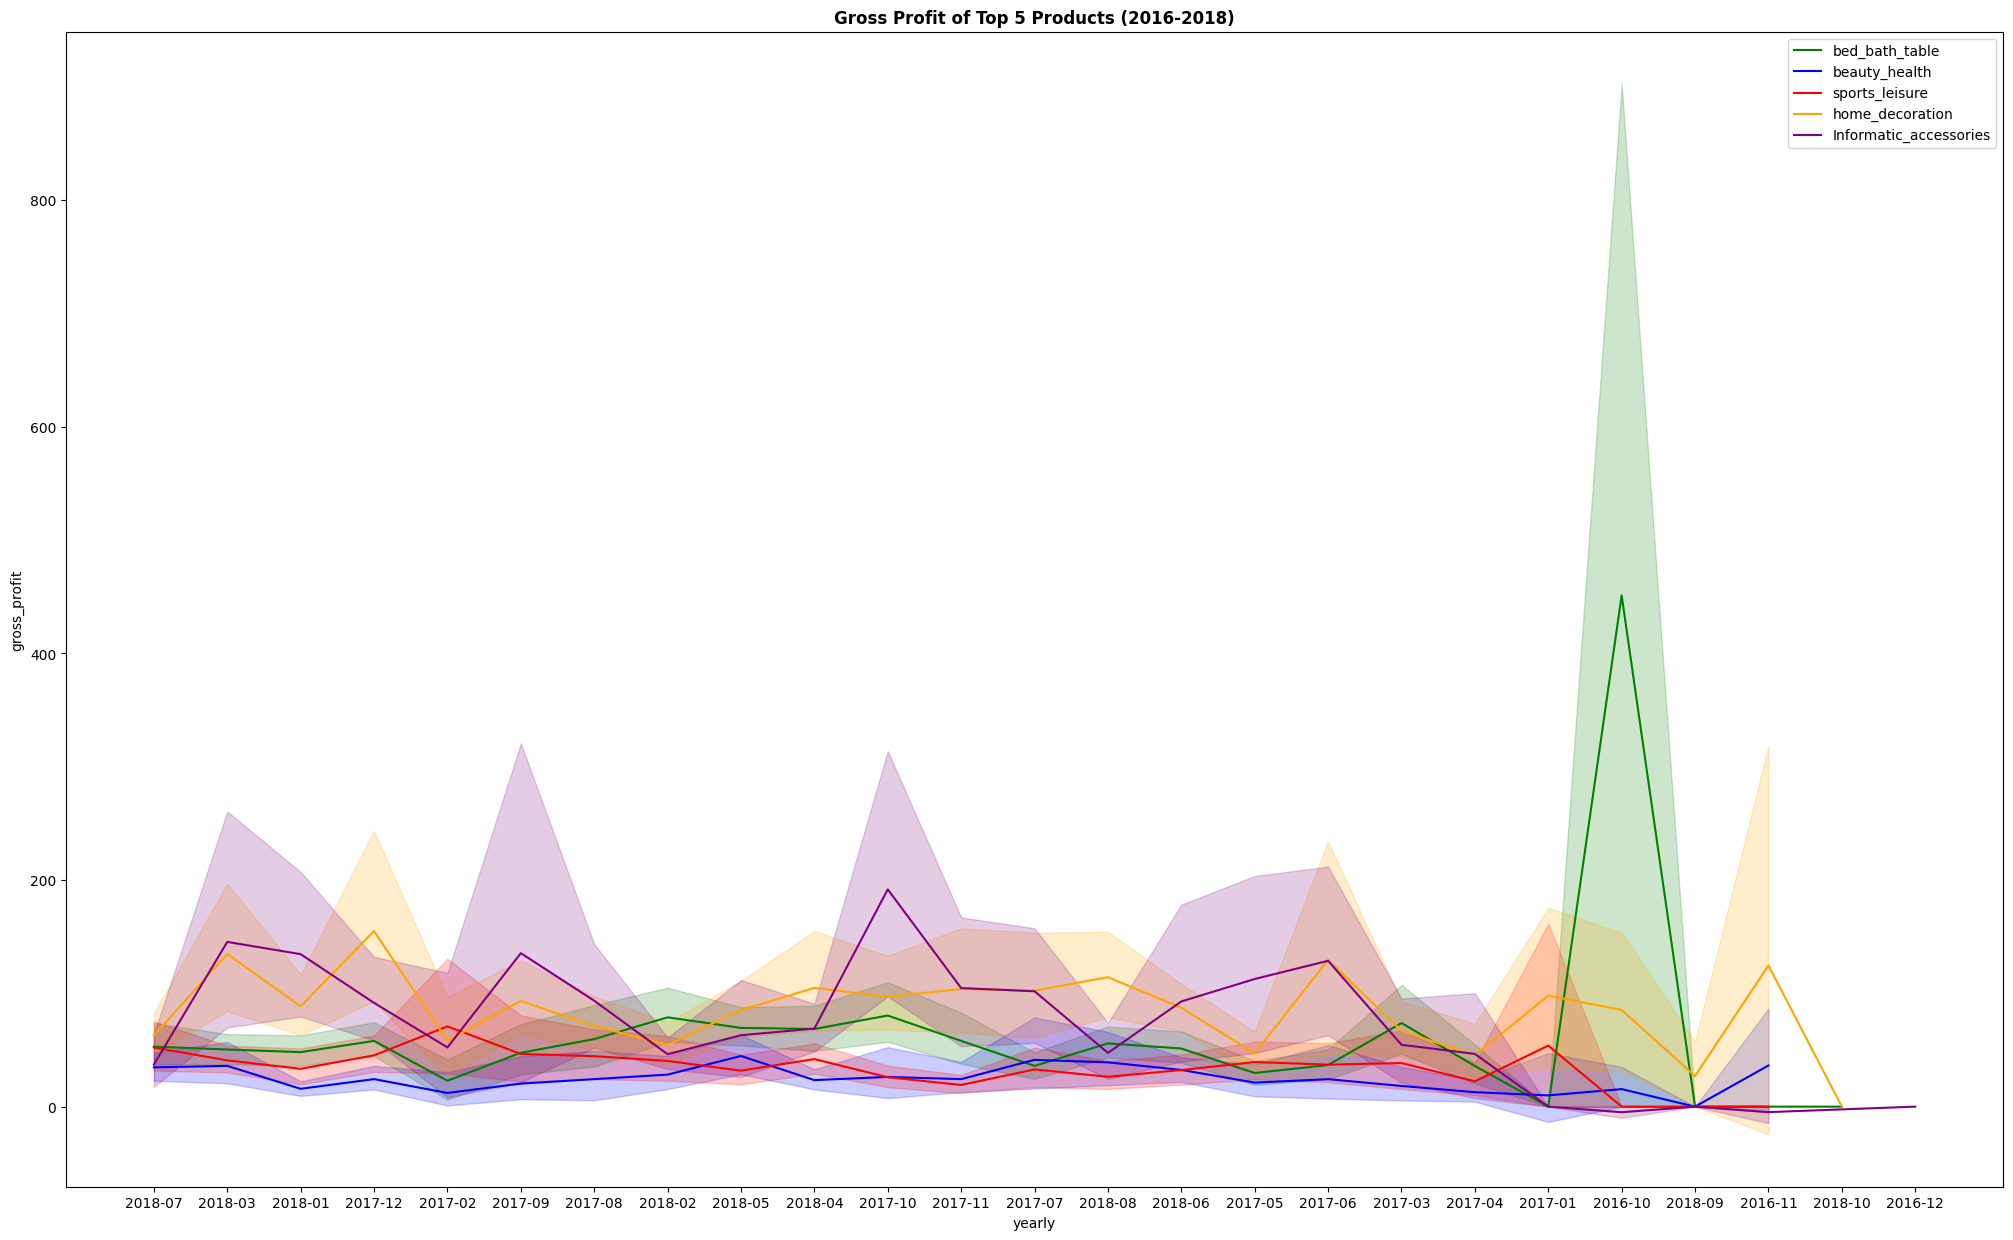

In [50]:
#  plot of yearly 'gross profit' distribution for the top 5 product category of ordered products and sellers

plt.figure(figsize=(25,15))

sns.lineplot(x='yearly',y='gross_profit',
             data=price_details[price_details['product_category_name']\
             =='cama_mesa_banho'], label='bed_bath_table',color="green")
sns.lineplot(x='yearly', y='gross_profit',
             data=price_details[price_details['product_category_name']\
             =='beleza_saude'], label='beauty_health', color="blue")
sns.lineplot(x='yearly', y='gross_profit',
             data=price_details[price_details['product_category_name']\
             =='esporte_lazer'], label='sports_leisure', color="red")
sns.lineplot(x='yearly', y='gross_profit',
             data=price_details[price_details['product_category_name']\
             =='moveis_decoracao'], label='home_decoration', color="orange")
sns.lineplot(x='yearly', y='gross_profit',
             data=price_details[price_details['product_category_name']\
             =='informatica_acessorios'], label='Informatic_accessories', color="purple")
plt.title("Gross Profit of Top 5 Products (2016-2018)",fontweight='bold')

informatic_accessories have the highest gross profit in Agust 2017 to November 2017. On the other hand, the top 3 products which are bed_bath_table, beauty_health and sports_leisure, gross profits are less than 200 units of currency.
bed_bath_table and home_decoration had peak gross profit in 2016

### 3.7 General Sales Analysis

I'll consolidate some of the above tables into one general 'sales' table, where each row is one order, and contains general information such as the customer, and costs, while removing any detail such as specific items, or payment types.

In [52]:
# combining orders and customers data
sales = pd.merge(orders, cust, how = 'left', on = 'customer_id')

In [53]:
#Dropping extra date columns
sales = sales.drop(columns = ['order_approved_at', 'order_delivered_carrier_date','order_delivered_customer_date', 'order_estimated_delivery_date'])


In [54]:
#Add items info to get price and freight value data
sales = pd.merge(sales, odr_item, how = 'left', on = 'order_id')

In [55]:
#drop unnecessary rows
sales = sales.drop(columns = ['seller_id', 'shipping_limit_date', 'order_item_id', 'product_id'])

In [56]:
#grouping by the order id and adding up price and freight value, to leave one row per order
sales = sales.groupby(by = ['order_id', 'customer_id', 'order_status',
                            'order_purchase_timestamp', 'customer_unique_id',
                            'customer_zip_code_prefix', 'customer_city', 'customer_state'],
                       as_index = False).agg({'price':'sum', 'freight_value':'sum'})

In [57]:
#add 'total_price' column for easier comparison
sales['total_price'] = sales['price'] + sales['freight_value']

In [58]:
#adding in payment infor to get payment made so far
sales = pd.merge(sales, pay, on = 'order_id')

In [59]:
#dropping excess data
sales = sales.drop(columns = ['payment_sequential', 'payment_type', 'payment_installments'])

In [60]:
#adding up all payments, again leaving one row per order
sales = sales.groupby(by = ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
                            'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
                            'customer_state', 'price', 'freight_value','total_price'], as_index = False).sum()


In [61]:
#Adding a 'balanace_remaining' column
sales['balance_remaining'] = sales['total_price'] - sales['payment_value']

In [62]:
#Adding in review data
sales = pd.merge(sales, review, on = 'order_id', how = 'left')

In [63]:
# checking the review_score only; all other data can be obtained if needed
sales = sales.drop(columns = ['review_comment_title', 'review_comment_message', 'review_creation_date',
                              'review_answer_timestamp', 'review_id'])


In [64]:
#renaming the columns
sales.rename(columns = {'order_purchase_timestamp':'order_date', 'customer_unique_id':'customer_un_id',
                        'customer_zip_code_prefix':'zip_prefix','customer_city':'city', 'customer_state':'state'}, inplace = True)


In [65]:
# check shape
sales.shape

(99991, 14)

In [66]:
# check head
sales.head()

,order_id,customer_id,order_status,order_date,customer_un_id,zip_prefix,city,state,price,freight_value,total_price,payment_value,balance_remaining,review_score
0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,58.90,13.29,72.19,72.19,0.000000e+00,5.0
1,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,239.90,19.93,259.83,259.83,0.000000e+00,4.0
2,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,199.00,17.87,216.87,216.87,0.000000e+00,5.0
3,00024acbcdf0a6daa1e931b038114c75,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,12.99,12.79,25.78,25.78,0.000000e+00,4.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,199.90,18.14,218.04,218.04,2.842171e-14,5.0


In [67]:
#check info

sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99991 entries, 0 to 99990
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   order_id           99991 non-null  object        
 1   customer_id        99991 non-null  object        
 2   order_status       99991 non-null  object        
 3   order_date         99991 non-null  datetime64[ns]
 4   customer_un_id     99991 non-null  object        
 5   zip_prefix         99991 non-null  int64         
 6   city               99991 non-null  object        
 7   state              99991 non-null  object        
 8   price              99991 non-null  float64       
 9   freight_value      99991 non-null  float64       
 10  total_price        99991 non-null  float64       
 11  payment_value      99991 non-null  float64       
 12  balance_remaining  99991 non-null  float64       
 13  review_score       99223 non-null  float64       
dtypes: dat

In [112]:
# interactive bar chart showing the % distribution of customers by state


# Calculate the percentage distribution of customers by state
state_counts = cust['customer_state'].value_counts(normalize=True) * 100

# Create an interactive bar chart using Plotly Express
fig = px.bar(
    x=state_counts.index,
    y=state_counts.values,
    labels={"x": "State", "y": "Percentage of Customers (%)"},
    title="Percentage Distribution of Customers by State",
    color=state_counts.index,  # Use state as color
    text=state_counts.values.round(1),  # Show percentage values on bars rounded to 1 decimal place
)

# Customize the chart
fig.update_layout(
    xaxis_title="State",
    yaxis_title="Percentage of Customers (%)",
    font=dict(family="Courier New, monospace", size=12, color="RebeccaPurple"),
    title_font_size=24,
    plot_bgcolor="white",
    paper_bgcolor="lightgray",
)

# Show the chart
fig.show()


42% of customers are from São Paulo (SP) state

#### ***3.7.1 Customer Lifetime Value (CLV) table***

The CLV table will be used for CLV analysis. It require 4 columns which can be taken from the 'sales' table created above.

In [68]:
sales_clv = sales[['customer_id', 'customer_un_id', 'order_date', 'price']]
sales_clv

,customer_id,customer_un_id,order_date,price
0,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,2017-09-13 08:59:02,58.90
1,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,2017-04-26 10:53:06,239.90
2,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,2018-01-14 14:33:31,199.00
3,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,2018-08-08 10:00:35,12.99
4,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,2017-02-04 13:57:51,199.90
...,...,...,...,...
99986,b51593916b4b8e0d6f66f2ae24f2673d,0c9aeda10a71f369396d0c04dce13a64,2018-04-23 13:57:06,299.99
99987,84c5d4fbaf120aae381fad077416eaa0,0da9fe112eae0c74d3ba1fe16de0988b,2018-07-14 10:26:46,350.00
99988,29309aa813182aaddc9b259e31b870e6,cd79b407828f02fdbba457111c38e4c4,2017-10-23 17:07:56,99.90
99989,b5e6afd5a41800fdf401e0272ca74655,eb803377c9315b564bdedad672039306,2017-08-14 23:02:59,55.99


In [115]:
# proportion of repeat customers vs one-time customers

# Calculate the number of orders per customer
customer_orders = sales_clv.groupby('customer_un_id')['customer_id'].count()

# Create a DataFrame to store the customer order counts
customer_orders_df = pd.DataFrame({'customer_un_id': customer_orders.index, 'order_count': customer_orders.values})

# Categorize customers as repeat or one-time
customer_orders_df['customer_type'] = np.where(customer_orders_df['order_count'] > 1, 'Repeat', 'One-time')

# Count the number of each customer type
customer_type_counts = customer_orders_df['customer_type'].value_counts()

# Create an interactive pie chart using Plotly Express
fig = px.pie(
    values=customer_type_counts.values,
    names=customer_type_counts.index,
    title="Proportion of Repeat vs One-time Customers",
    hole=0.3,  # Add a hole in the center
    labels={"value": "Number of Customers", "name": "Customer Type"},
)

# Customize the chart
fig.update_traces(
    textinfo='percent+label',  # Display both percentage and label
    textfont_size=14,
    marker=dict(line=dict(color='white', width=2))  # Add a white border to the slices
)

# Show the chart
fig.show()


#### ***3.7.2 Sales by Day***

The table has one row per day, with total number of orders and sales for that day. This allows us to do some time series analysis. It will be used to graph sales, and order by day, and then for sales forecasting.

In [69]:
# extracting required  columns
sales_date = sales[['order_date', 'order_id', 'price']]

# converting 'order_date'  to datetime
sales_date['order_date'] = pd.to_datetime(sales_date['order_date'])

# dropping time from 'order_date'
sales_date['order_date'] = sales_date['order_date'].dt.date

# aggregating orders and  price so  there is one  row per date
sales_date = sales_date.groupby(by = 'order_date', as_index = False).agg({'order_id':'count', 'price':'sum'})

sales_date

<ipython-input-69-8c301fd3b144>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_date['order_date'] = pd.to_datetime(sales_date['order_date'])
<ipython-input-69-8c301fd3b144>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_date['order_date'] = sales_date['order_date'].dt.date


,order_date,order_id,price
0,2016-09-04,1,72.89
1,2016-09-05,1,59.50
2,2016-09-13,1,0.00
3,2016-10-02,1,100.00
4,2016-10-03,8,463.48
...,...,...,...
628,2018-09-29,1,0.00
629,2018-10-01,1,0.00
630,2018-10-03,1,0.00
631,2018-10-16,1,0.00


In [70]:
# extracting required  columns
sales_date = sales[['order_date', 'order_id', 'price']]

In [71]:
# converting 'order_date'  to datetime
sales_date['order_date'] = pd.to_datetime(sales_date['order_date'])

<ipython-input-71-88cd2aeab79a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_date['order_date'] = pd.to_datetime(sales_date['order_date'])


In [72]:
# dropping time from 'order_date'
sales_date['order_date'] = sales_date['order_date'].dt.date

<ipython-input-72-ab04f9c94e22>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_date['order_date'] = sales_date['order_date'].dt.date


In [73]:
# aggregating orders and  price so  there is one  row per date
sales_date = sales_date.groupby(by = 'order_date', as_index = False).agg({'order_id':'count', 'price':'sum'})

In [74]:
sales_date

,order_date,order_id,price
0,2016-09-04,1,72.89
1,2016-09-05,1,59.50
2,2016-09-13,1,0.00
3,2016-10-02,1,100.00
4,2016-10-03,8,463.48
...,...,...,...
628,2018-09-29,1,0.00
629,2018-10-01,1,0.00
630,2018-10-03,1,0.00
631,2018-10-16,1,0.00


#### ***3.7.3 Sales Exploratory Analysis***

***Basic Sales Statistics***

In [75]:
#check basic statistics from 'sales' table
sales.describe()

,order_date,zip_prefix,price,freight_value,total_price,payment_value,balance_remaining,review_score
count,99991,99991.000000,99991.000000,99991.000000,99991.000000,99991.000000,99991.000000,99223.000000
mean,2017-12-31 01:10:03.958906112,35140.861318,136.530173,22.641441,159.171614,160.828682,-1.657068,4.086452
min,2016-09-04 21:15:19,1003.000000,0.000000,0.000000,0.000000,0.000000,-3782.190000,1.000000
25%,2017-09-12 08:44:45,11347.000000,45.000000,13.720000,61.020000,61.990000,0.000000,4.000000
50%,2018-01-18 16:45:53,24416.000000,85.000000,17.090000,104.380000,105.280000,0.000000,5.000000
75%,2018-05-04 09:53:41,58900.000000,149.900000,23.920000,175.895000,176.830000,0.000000,5.000000
max,2018-10-17 17:30:18,99990.000000,13440.000000,1794.960000,13664.080000,13664.080000,51.620000,5.000000
std,NaN,29800.135154,209.814624,21.633105,219.695996,221.580101,36.654467,1.347550


- The average price for each order is 136, with an average total price of 159.

- 75% of total price is 175, thus only 16 more than the mean, and then the max being 13,664 tells us that there may be a few outliers that may need to be dealt with later.

- The negative balance_remaining numbers, and likely related, the average payment_value being greater than average total_price, will need to be looked at and addressed.

- The average review score is 4, and we can look into potential ways to increase that.

***Basic Product Statistics***

In [76]:
#check basic statistic for the 'product' table
prod.describe()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32341.000000,32341.000000,32341.000000,32949.000000,32949.000000,32949.000000,32949.000000
mean,48.476949,771.495285,2.188986,2276.472488,30.815078,16.937661,23.196728
std,10.245741,635.115225,1.736766,4282.038731,16.914458,13.637554,12.079047
min,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,57.000000,972.000000,3.000000,1900.000000,38.000000,21.000000,30.000000
max,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000


***Descriptive Visualizations***

**Price**

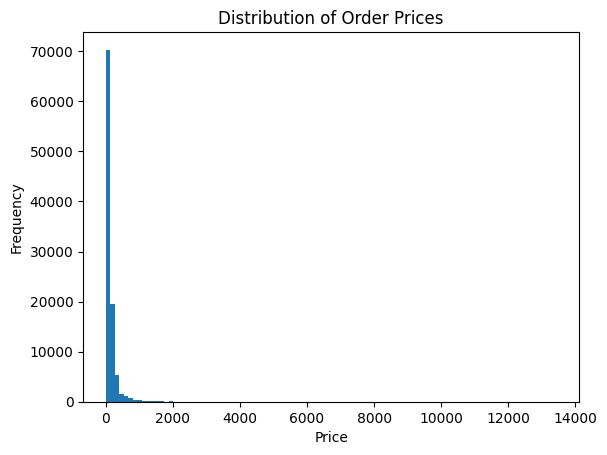

In [99]:
# Plotting a histogram for the 'price' column

plt.hist(sales['price'], bins=100)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Order Prices')
plt.show()

We can see that there is a huge tail in the histogram.

We'll plot the same histogram using logarithmic scale, to better see the tail, then zoom in to better see most of the data.

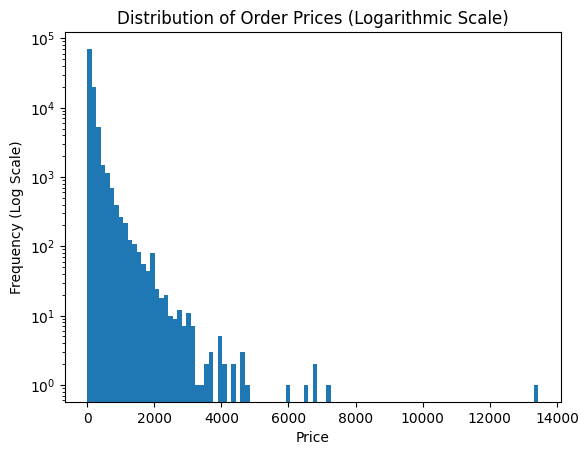

In [98]:
# Plotting a histogram for the 'price' column with log scale

plt.hist(sales['price'], bins=100, log=True)
plt.xlabel('Price')
plt.ylabel('Frequency (Log Scale)')
plt.title('Distribution of Order Prices (Logarithmic Scale)')
plt.show()


Most of the data is less than 5000, with a few from 6000-7500, and one out at the end almost to 14,000.

I'll zoom in again to better see most of the data, not in log scale.

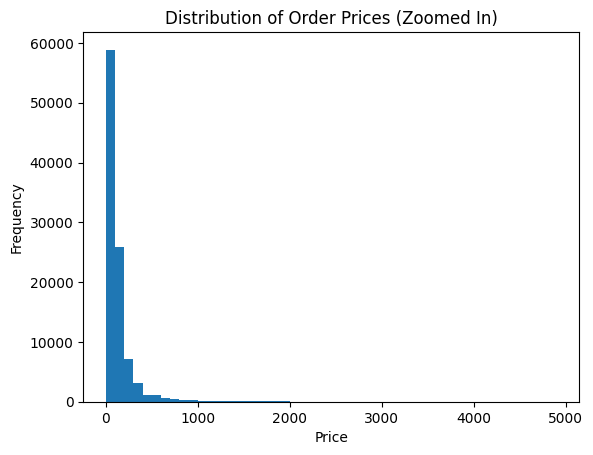

In [100]:
# zooming in to 0 to 5000
plt.hist(sales['price'], bins=range(0, 5000, 100))

# Adding labels and title
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Order Prices (Zoomed In)')

# Display the plot
plt.show()


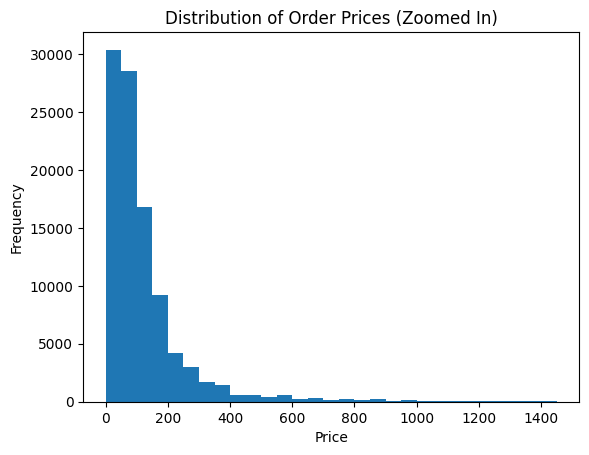

In [101]:
# Zooming in to 0 to 1500
plt.hist(sales['price'], bins=range(0, 1500, 50))

# Adding labels and title
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Order Prices (Zoomed In)')

# Display the plot
plt.show()


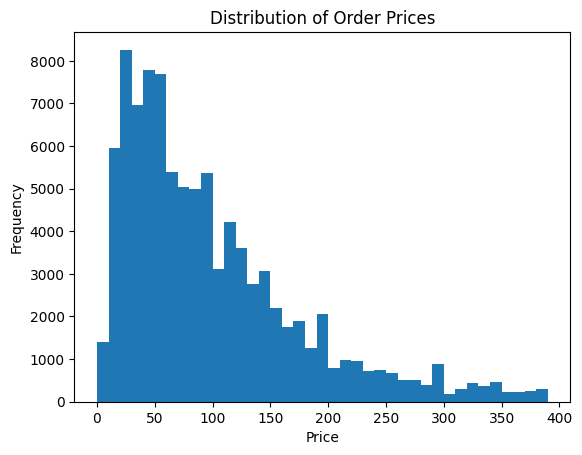

In [102]:
# Plotting the histogram
plt.hist(sales['price'], bins=range(0, 400, 10))

# Adding labels and title
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Order Prices')

# Display the plot
plt.show()


The distributions above show that the price is right-skewed, with some major outliers that will need to be considered when dealing with certain algorithms.

We can also see that the vast majority of the data is less than 400

**Reviews**

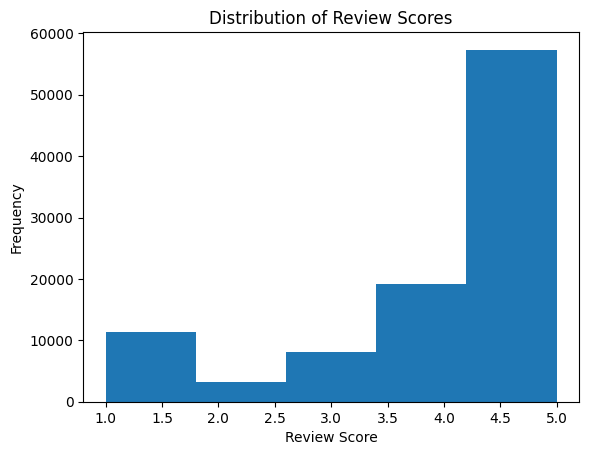

In [103]:
# histogram of sales ['review_score'], with bins = 5
plt.hist(sales['review_score'], bins=5)

# Adding labels and title
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.title('Distribution of Review Scores')

# Display the plot
plt.show()


- Most of the reviews are 5 star reviews, and then 4 stars.

- There is also a good amount of 1 star reviews that we could look into, to see if there are specific products, locations, times, etc. that result in a lower review score.

**Freight**

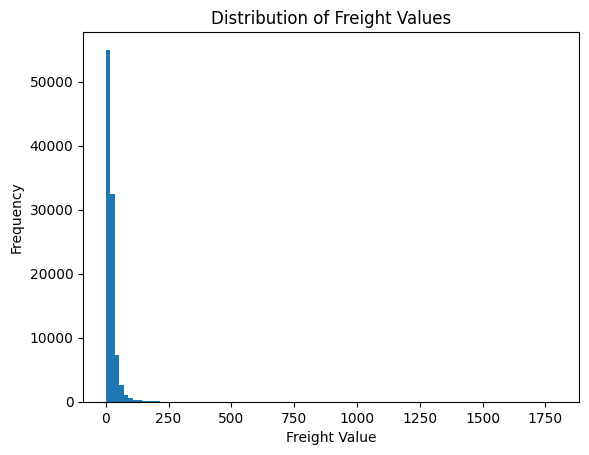

In [104]:
# histogram of sales ['freight_value'], with bins = 100
plt.hist(sales['freight_value'], bins=100)

# Adding labels and title
plt.xlabel('Freight Value')
plt.ylabel('Frequency')
plt.title('Distribution of Freight Values')

# Display the plot
plt.show()


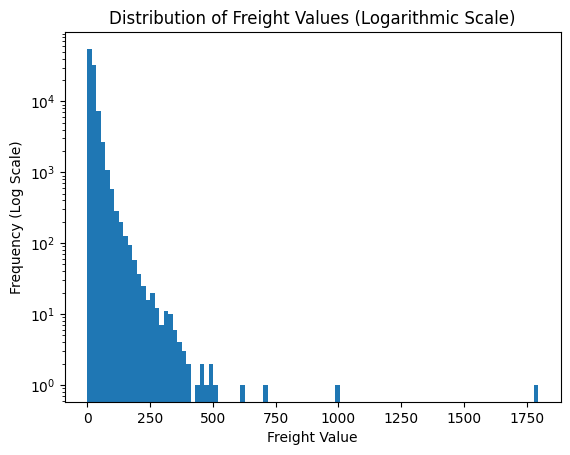

In [105]:
# histogram of sales ['freight_value'], with bins = 100, and log = True
plt.hist(sales['freight_value'], bins=100, log=True)

# Adding labels and title
plt.xlabel('Freight Value')
plt.ylabel('Frequency (Log Scale)')
plt.title('Distribution of Freight Values (Logarithmic Scale)')

# Display the plot
plt.show()


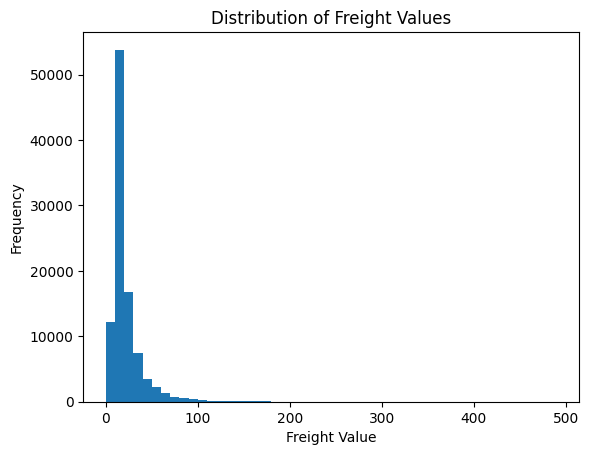

In [106]:
# histogram of sales ['freight_value'], with bins = range(0,500,10)
plt.hist(sales['freight_value'], bins=range(0, 500, 10))

# Adding labels and title
plt.xlabel('Freight Value')
plt.ylabel('Frequency')
plt.title('Distribution of Freight Values')

# Display the plot
plt.show()


- The distributions for freight resemble those for 'price' distributions, being heavily right-skewed with a few outliers.

- Next, we will check the correlation between price and freight.

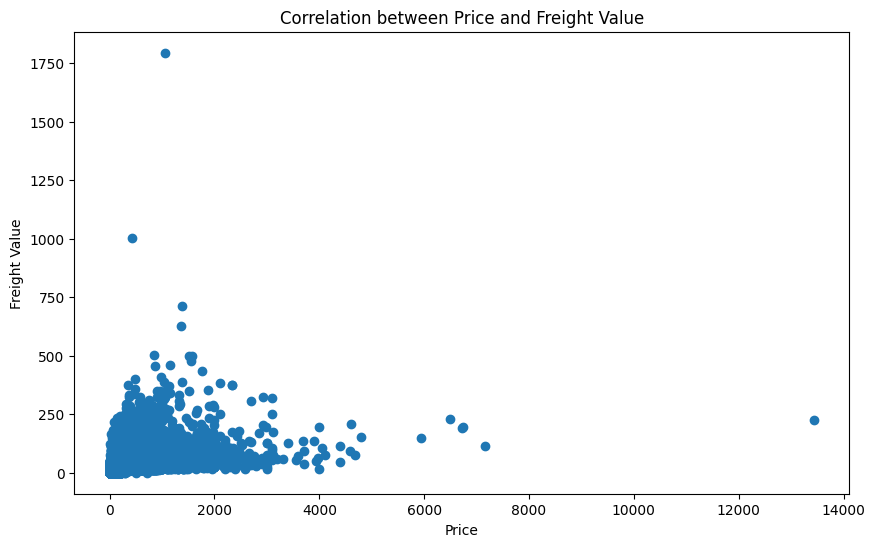

In [88]:
# scatter plot to analyze the correlation between price and freight_value for sales

plt.figure(figsize=(10, 6))
plt.scatter(sales['price'], sales['freight_value'])
plt.xlabel('Price')
plt.ylabel('Freight Value')
plt.title('Correlation between Price and Freight Value')
plt.show()


In [89]:
sales['price'].corr(sales['freight_value'])

0.41597397459698754

There is a positive correlation between freight and price, but not much.

In [90]:
item_prod = pd.merge(odr_item, prod, on = 'product_id')
item_prod

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,ffebd80e3291e811c308365936897efd,1,4cc4d02efc8f249c13355147fb44e34d,d1c7fa84e48cfa21a0e595167c1c500e,2018-07-18 20:23:55,129.9,51.20,ferramentas_jardim,37.0,653.0,1.0,6700.0,35.0,12.0,22.0
112646,ffee31fb4b5e35c9123608015637c495,1,b10ecf8e33aaaea419a9fa860ea80fb5,0241d4d5d36f10f80c644447315af0bd,2018-08-21 10:10:11,99.0,13.52,moveis_decoracao,30.0,308.0,1.0,2300.0,37.0,30.0,20.0
112647,fff7c4452f050315db1b3f24d9df5fcd,1,dd469c03ad67e201bc2179ef077dcd48,7e93a43ef30c4f03f38b393420bc753a,2017-06-07 17:05:23,736.0,20.91,relogios_presentes,33.0,658.0,3.0,400.0,19.0,9.0,15.0
112648,fffa82886406ccf10c7b4e35c4ff2788,1,bbe7651fef80287a816ead73f065fc4b,8f2ce03f928b567e3d56181ae20ae952,2017-12-22 17:31:42,229.9,44.02,esporte_lazer,32.0,280.0,2.0,2700.0,60.0,15.0,15.0


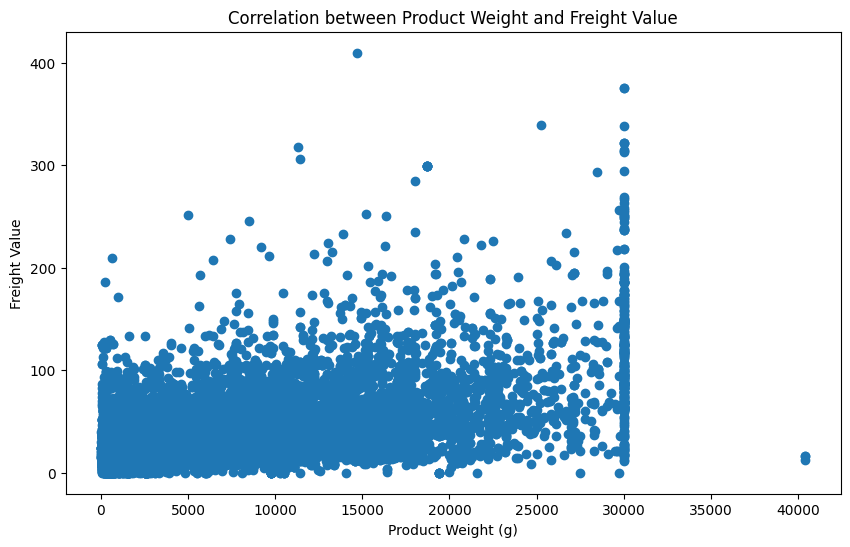

In [91]:
# scatter plot to analyze the correlation between product_weight_g and freight_value

plt.figure(figsize=(10, 6))
plt.scatter(item_prod['product_weight_g'], item_prod['freight_value'])
plt.xlabel('Product Weight (g)')
plt.ylabel('Freight Value')
plt.title('Correlation between Product Weight and Freight Value')
plt.show()


In [92]:
item_prod['product_weight_g'].corr( item_prod['freight_value'])

0.6104202350972822

There is a high positive correlation between product_weight_g and freight_value.

This is much expected.

In [93]:
item_prod['total_volume'] = item_prod['product_length_cm'] * item_prod['product_width_cm'] * item_prod['product_height_cm']

In [94]:
item_prod['total_volume'].corr( item_prod['freight_value'])

0.5872700711964546

There is a high positive correlation, although slightly lower than with the product_weight_g.

With the above, we can see that weight and total volume of the product are highly correlated with freight. Intuitively this makes sense, as the bigger and heavier an item is, the more it costs in freight, but it's good not to assume, and to ensure the data matches our intuitions.

**Sales Over Time**

***Daily Sales Amounts***

In [95]:
figure = px.line(sales_date, x = 'order_date', y = 'price')
figure.show()

***Daily Number of Orders***

In [96]:
figure = px.line(sales_date, x = 'order_date', y = 'order_id')
figure.show()

- There is a huge spike in both orders and sales amount on Nov. 24, 2017. This coincides with Black Friday.

- There is also a generally upward trend, with cyclical peaks and dips.

### **4. Insights**

- 42% of the retailer's customer base is from São Paulo but only 6% of these buyers are repeat customers. Acre has the highest retention rate followed Rondonia, both with a retention rate above 10%.

- Bed_bath_table generated the most revenue for the retailer, but computers generated the highest average revenue. Most people are therefore buying products from bed_bath_table category but spending more money buying products from computers category.

- Most of the customers are one time customers. Only 3,081 (3.21%) customers have made repeat purchases on the platform. The oline retailer needs to implement strategies that will turn their customers into loyal clients.

- The most preferred payment method by customers is credit cards followed by boleto.

- The top selling product category in terms of the number of orders made is bed_bath_table with the least being security_and_services with only 2 orders.

- Most of the retailer's customers seem to be satisfied with their orders and also having a good purchase experience on the platform since the average order cancellation rate is 0.62.

- Customers who spent the most money ended up rating their orders with a score of 1, which signifies they were not impressed. Customers therefore prefer spending their money on the low priced categories due to their positive review scores.

- The average and total revenue has been on an upward trend for the two years.

- There is an increase in the number of orders placed on the online retail platform across the years. This is a good indicator since it shows that more and more people are getting to know about the platform.

- Categories that had an above average rating score performed better than those below average.

- The online retail store has 2970 active sellers and most of these sellers are from the state of São Paulo.

### **5. Recommendations**

- Most of retail store's customers are from São Paulo (SP), while Acre and Rondonia had the highest customer retention rate respectively. Introducing marketing strategies such as loyalty programs eg redeemable loyalty points, free shipping, discounts etc. in these areas will help get more people into the platform and also turn one time customers into loyal clients.

- Highly priced product categories have low review scores. In order to increase the revenue in these categories, the retail store should check reviews on these products to help them better the experience of customers. It will also be wise to review the sellers in these categories and evaluate the products they are selling before they post their products on the platform. This will help improve the customer experience for the retail store.

- Computers generate low revenue due to low number of orders made. Sales promotions such as discounts, upselling, pricing strategies would increase the sales made which leads to more revenue generated.